# Classification de séries temporelles de conductance stomatique (gsw) selon leur traitement hydrique avec un Random Forest

On commence par importer l'ensemble des librairies et des méthodes nécessaires

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score
from scipy.stats import randint

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

### Préparation des données

On télécharge le fichier de données

In [ ]:
fichier_csv = "fake_path\Data_gsw_4.csv"

On visualise l'ensemble des données

In [ ]:
data_gsw = pd.read_csv(fichier_csv, index_col='Unnamed: 0')
data_gsw.head()

,tree,gsw1,gsw2,gsw3,gsw4,gsw5,gsw6,gsw7,gsw8,gsw9,gsw10,gsw11,gsw12,treatment,specie,water_stress,heat_stress
1,PT_WW_1_1,0.3316,NaN,NaN,NaN,0.6592,NaN,NaN,0.5178,NaN,NaN,NaN,0.4540,WW_25,PT,WW,25
2,CE_D_2_1,0.0409,NaN,NaN,NaN,0.0876,NaN,NaN,0.1379,NaN,NaN,NaN,0.1149,WW_25,CE,WW,25
3,TA_D_3_1,0.0205,NaN,NaN,NaN,0.0855,NaN,NaN,0.0445,NaN,NaN,NaN,0.1186,WW_25,TA,WW,25
4,PE_WW_4_1,0.0491,NaN,NaN,NaN,0.0195,NaN,NaN,0.0230,NaN,NaN,NaN,0.0001,WW_25,PE,WW,25
5,SE_WW_5_1,0.0969,NaN,NaN,NaN,0.1701,NaN,NaN,0.2207,NaN,NaN,NaN,0.1748,WW_25,SE,WW,25


On transforme la colonne correspondant au traitement hydrique : WW ou D, en deux colonnes binaires D (qui prend les instances 0 ou 1) et WW (qui prend les instances 0 ou 1).

In [ ]:
data_gsw["dummy"] = 1
data_gsw_wide = data_gsw.pivot(index=data_gsw.iloc[:, np.r_[0:13]],
                                                             columns=["water_stress"], values= "dummy").reset_index()
data_gsw_wide = data_gsw_wide.fillna(0)

On sélectionne les colonnes en entrée : on garde seulement l'information des séries temporelles. On définit ensuite la colonne binaire D comme la sortie de l'algorithme.  

In [ ]:
X = data_gsw_wide.iloc[:, np.r_[1:13]]

y = data_gsw_wide.iloc[:, np.r_[13]]
y = y.values.ravel()

On sous échantillonne le jeu de doonées en deux : les valeurs sur lesquelles le modèle s'entraine (80%) et les valeurs à partir duquel le modèle est évalué (20%).


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Random forest - programme principal

On définit les différents composantes de notre modèle : il s'agit d'un Random Forest (composé de 350 arbres de profondeur maximale 14). On utilise la méthode SMOTE pour enrichir le jeu de données déséquilibré. On sous-échantillonne ensuite les données majoritaires.

In [ ]:
rf =  RandomForestClassifier(max_depth=14, n_estimators=350)
over = SMOTE()
under = RandomUnderSampler()
steps = [('over', over), ('under', under), ('rf', RandomForestClassifier(max_depth=14, n_estimators=350))]
pipeline = Pipeline(steps=steps)

On se place dans un cas de cross validation d'ordre 5 pour appuyer avec robustesse le résultat de notre modèle. On choisit une métrique d'évaluation du modèle adapté à nos données.

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Mean f1 weighted: %.3f' % np.mean(scores))

Mean f1 macro: 0.817


### Random Forest - programme annexe

On ne se place plus dans un cas de cross validation, on est alors plus sensible à l'échantillonnage des données à tester par rapport aux données d'entrainement. On segmente davantage les taches de l'algorithme pour une meilleure lecture. On cherche les hyperparamètres (profondeur maximale et nombre d'arbres) les plus adaptés à la classification de nos données.


On calcule le déséquilibre des classes.

In [ ]:
counter = Counter(y_train)
counter

Counter({0.0: 818, 1.0: 334})

On résout le déséquilibre en enrichissant la classe minoritaire du jeu de données par la méthode SMOTE. On sous échantillone la classe majoritaire.

In [ ]:
over = SMOTE()
under = RandomUnderSampler()
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

On calcule le nouveau déséquilibre des classes de la sortie.

In [ ]:
counter = Counter(y_resampled)
counter

Counter({0.0: 818, 1.0: 818})

On cherche les meilleurs hyperparamètres pour le random forest classfier adapté à nos données.

In [ ]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=5)

rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7baf699c9de0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7baf699c9a20>})

In [ ]:
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 6, 'n_estimators': 411}


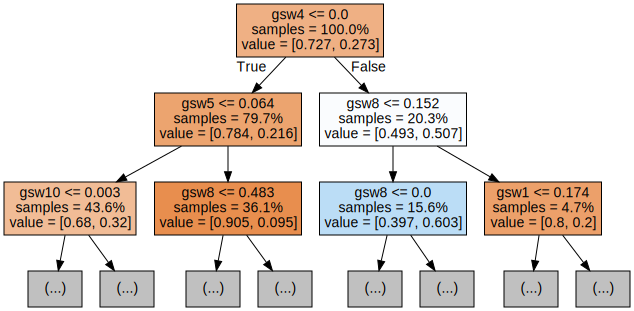

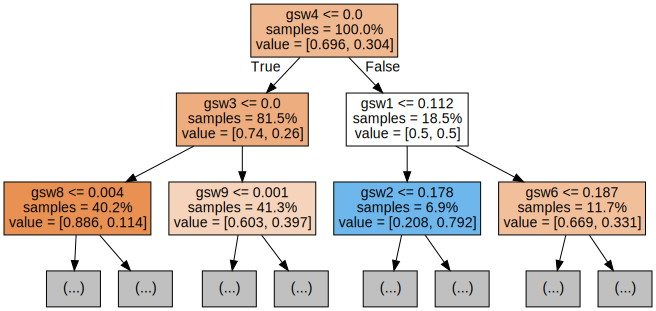

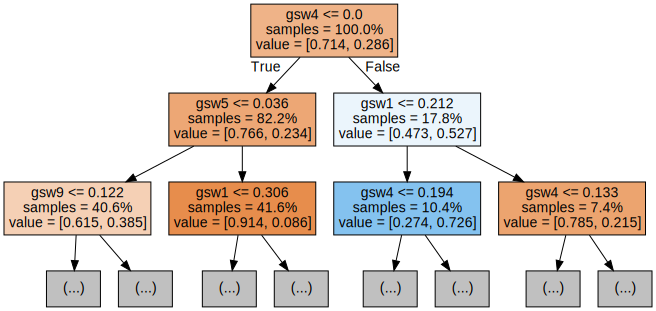

In [ ]:
for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

    output_file = f'tree_{i}.pdf'
    graph.render(output_file, format='pdf')

In [ ]:
from google.colab import files

files.download('tree_1.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

On applique le modèle avec le meilleur modèle à notre jeu de données test, auquel le modèle est aveugle pendant son entrainement.

In [ ]:
y_pred = best_rf.predict(X_test)

On évalue les performances de notre modèle avec le f1_macro. C'est une métrique adaptée pour des données déséquilibrée et la plus simple à utiliser car elle résume à la fois les préoccupations de précision et de rappel en un seul chiffre.

In [ ]:
f1_macro = f1_score(y_test, y_pred, average="weighted") # calculate the f1_score

print("F1 score weighted", f1_macro)

F1 score macro 0.7757104625971709


On évalue notre modèle avec des métriques complémentaires : l'exactitude, la précision et le rappel.

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8090277777777778
Precision: 0.6777777777777778
Recall: 0.7011494252873564


On représente enfin la matrice dite de confusion qui permet de classer les visualiser les données mal classées, faux positifs et faux négatifs.

[[172  29]
 [ 26  61]]


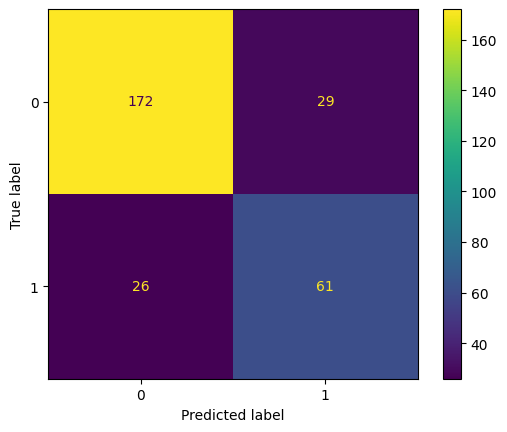

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()